In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from matplotlib.ticker import AutoMinorLocator
from matplotlib import gridspec

#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn import metrics

from google.colab import files


In [ ]:
#caricamento del dataset
df = pd.read_csv('words_glasgow.csv')
#faccio una copia del dataset in caso di manipolazione dati
dfcopy= df.copy()

In [ ]:
df2 = df.copy()
df2["perceivability"] = df2[["imageability", "concreteness"]].mean(axis=1)
df_perc=df2.drop(["concreteness","imageability"], axis=1)
dfprepro= df_perc.copy()
dfprepro=dfprepro.rename(columns={"gender": "masculinity"})
dfprepro.loc[(dfprepro['web_corpus_freq'].isnull() == True), 'web_corpus_freq'] = dfprepro['web_corpus_freq'].mean()
dfprepro["web_corpus_log"] = pd.qcut(dfprepro["web_corpus_freq"], 10) #taglio la variabile web_corpus_freq in 10 gruppi
dataframe = [dfprepro]
for dataset in dataframe:
    dataset.loc[(dataset["web_corpus_freq"] > 10000) & (dataset["web_corpus_freq"] <= 100000), "web_corpus_freq"] = 4
    dataset.loc[(dataset["web_corpus_freq"] > 100000) & (dataset["web_corpus_freq"] <= 1000000), "web_corpus_freq"] = 5
    dataset.loc[(dataset["web_corpus_freq"] > 1000000) & (dataset["web_corpus_freq"] <= 10000000), "web_corpus_freq"] = 6
    dataset.loc[(dataset["web_corpus_freq"] > 10000000) & (dataset["web_corpus_freq"] <= 100000000), "web_corpus_freq"] = 7
    dataset.loc[(dataset["web_corpus_freq"] > 100000000) & (dataset["web_corpus_freq"] <= 1000000000), "web_corpus_freq"] = 8
    dataset.loc[dataset["web_corpus_freq"] > 1000000000, "web_corpus_freq"] = 9
dfprepro = dfprepro.drop(["web_corpus_log","word"], axis=1)


# Preprocess for classification

In [ ]:
# per il decision tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# visualizzarlo
from sklearn import tree
import pydotplus 
from IPython.display import Image 

# evaluazione
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score

# hyperparameter tuning
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
# cross-validation
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

In [ ]:
df_class_ref = dfprepro.copy()
var_to_scale=['aoa',"arousal","valence","dominance","familiarity","semsize","masculinity","perceivability"]

features = df_class_ref[var_to_scale]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

df_class_ref[var_to_scale] = features


In [ ]:
df_class_ref

,length,arousal,valence,dominance,familiarity,aoa,semsize,masculinity,polysemy,web_corpus_freq,perceivability
0,8,0.350163,0.240777,0.372006,0.138889,0.963317,0.591837,0.735388,0,5.0,0.609099
1,5,0.174510,0.623736,0.423950,0.316893,0.688108,0.676540,0.385698,0,6.0,0.746168
2,10,0.198693,0.554024,0.512286,0.656463,0.751739,0.233339,0.497572,0,5.0,0.278825
3,8,0.349183,0.359328,0.385381,0.439153,0.871697,0.596713,0.697873,0,5.0,0.222201
4,10,0.292320,0.374163,0.444635,0.273998,0.901947,0.669677,0.598057,0,5.0,0.220248
...,...,...,...,...,...,...,...,...,...,...,...
4677,8,0.674510,0.521203,0.527527,0.287226,0.837448,0.738487,0.714956,0,6.0,0.865371
4678,4,0.322549,0.413811,0.408398,0.873394,0.246349,0.069171,0.531234,0,7.0,0.291321
4679,4,0.639216,0.759879,0.650078,0.444633,0.720619,0.227741,0.410651,0,5.0,0.474861
4680,3,0.629412,0.683340,0.551166,0.757370,0.192107,0.626513,0.512309,0,7.0,0.873963


### Arousal

In [ ]:
refvar="arousal"
taglio=0.55

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

[Text(534.7704919477663, 399.546, 'valence <= 0.698\ngini = 0.372\nsamples = 3511\nvalue = [2645, 866]\nclass = not aroused'),
 Text(355.33135788018956, 383.238, 'semsize <= 0.638\ngini = 0.25\nsamples = 2829\nvalue = [2414, 415]\nclass = not aroused'),
 Text(185.56261986687727, 366.93, 'semsize <= 0.496\ngini = 0.164\nsamples = 2299\nvalue = [2092, 207]\nclass = not aroused'),
 Text(95.9751029444946, 350.62199999999996, 'masculinity <= 0.369\ngini = 0.101\nsamples = 1542\nvalue = [1460, 82]\nclass = not aroused'),
 Text(29.20938628158845, 334.31399999999996, 'semsize <= 0.366\ngini = 0.25\nsamples = 171\nvalue = [146, 25]\nclass = not aroused'),
 Text(16.115523465703973, 318.006, 'valence <= 0.654\ngini = 0.142\nsamples = 117\nvalue = [108, 9]\nclass = not aroused'),
 Text(8.057761732851986, 301.698, 'web_corpus_freq <= 5.5\ngini = 0.063\nsamples = 92\nvalue = [89, 3]\nclass = not aroused'),
 Text(4.028880866425993, 285.39, 'aoa <= 0.251\ngini = 0.231\nsamples = 15\nvalue = [13, 2]\nc

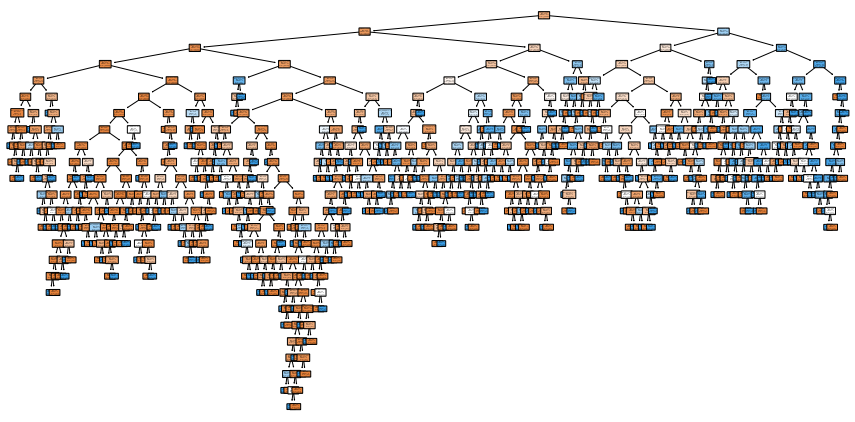

In [ ]:
plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt,
          filled=True,
          rounded=True,
          class_names=["not aroused","aroused"],
          feature_names=X.columns)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


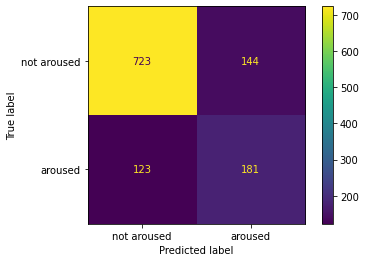

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score

plot_confusion_matrix(clf_dt, X_test, y_test, display_labels=["not aroused","aroused"])

Accuracy 0.7719897523484202
F1-score [0.8441331  0.57551669]
              precision    recall  f1-score   support

         0.0       0.85      0.83      0.84       867
         1.0       0.56      0.60      0.58       304

    accuracy                           0.77      1171
   macro avg       0.71      0.71      0.71      1171
weighted avg       0.78      0.77      0.77      1171

0.7146523857220907


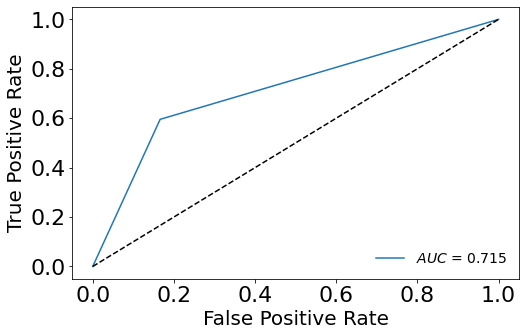

In [ ]:
y_pred = clf_dt.predict(X_train)
y_pred = clf_dt.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf_dt.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

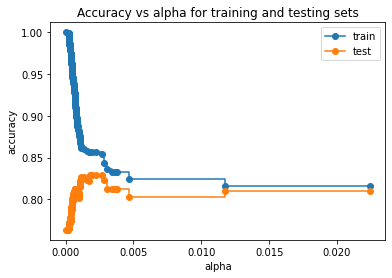

In [ ]:
train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

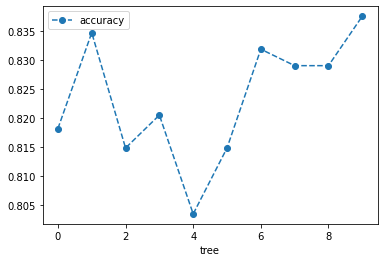

In [ ]:
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=0.003)

scores= cross_val_score(clf_dt,X_train,y_train, cv=10)

df=pd.DataFrame(data={'tree':range(10), 'accuracy':scores})

df.plot(x='tree', y='accuracy',marker='o',linestyle='--')


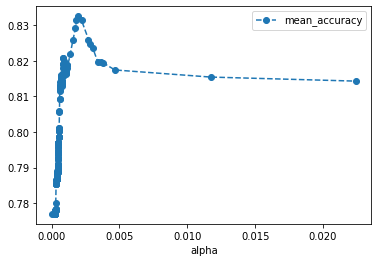

In [ ]:
alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


In [ ]:
alpha_results[(alpha_results['alpha']>0.001)
&
(alpha_results['alpha']<0.005)]

,alpha,mean_accuracy,std
184,0.001005,0.818000,0.012653
185,0.001007,0.817716,0.012614
186,0.001043,0.816295,0.015042
187,0.001060,0.816580,0.013443
188,0.001069,0.817434,0.012723
189,0.001077,0.816864,0.013201
190,0.001083,0.817719,0.015355
191,0.001091,0.818004,0.015112
192,0.001136,0.818858,0.015519
193,0.001139,0.818858,0.015519


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

In [ ]:
clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


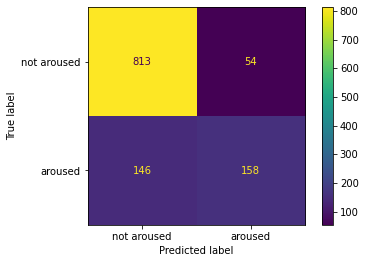

In [ ]:
plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not aroused','aroused'])

[Text(460.35, 378.5785714285714, 'valence <= 0.698\ngini = 0.372\nsamples = 3511\nvalue = [2645, 866]\nclass = not aroused'),
 Text(251.10000000000002, 320.3357142857143, 'semsize <= 0.638\ngini = 0.25\nsamples = 2829\nvalue = [2414, 415]\nclass = not aroused'),
 Text(83.7, 262.09285714285716, 'semsize <= 0.496\ngini = 0.164\nsamples = 2299\nvalue = [2092, 207]\nclass = not aroused'),
 Text(41.85, 203.85, 'gini = 0.101\nsamples = 1542\nvalue = [1460, 82]\nclass = not aroused'),
 Text(125.55000000000001, 203.85, 'masculinity <= 0.239\ngini = 0.276\nsamples = 757\nvalue = [632, 125]\nclass = not aroused'),
 Text(83.7, 145.60714285714283, 'gini = 0.298\nsamples = 11\nvalue = [2, 9]\nclass = aroused'),
 Text(167.4, 145.60714285714283, 'dominance <= 0.603\ngini = 0.263\nsamples = 746\nvalue = [630, 116]\nclass = not aroused'),
 Text(125.55000000000001, 87.3642857142857, 'gini = 0.225\nsamples = 658\nvalue = [573, 85]\nclass = not aroused'),
 Text(209.25, 87.3642857142857, 'gini = 0.456\nsam

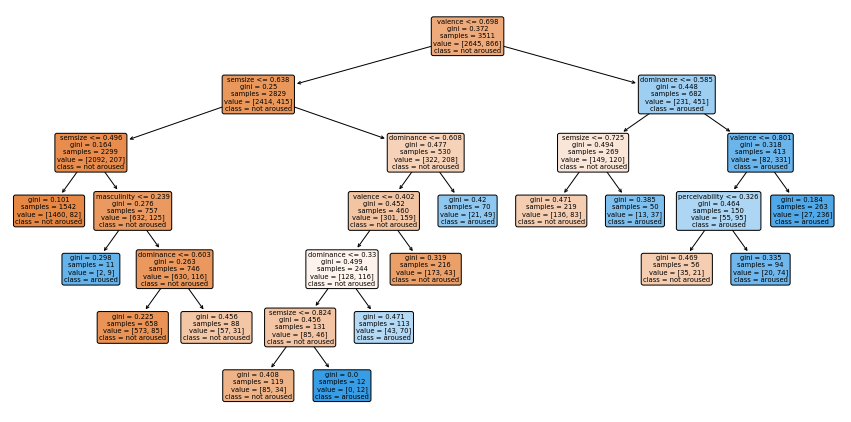

In [ ]:
plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not aroused","aroused"],
          feature_names=X.columns)

Accuracy 0.829205807002562
F1-score 0.8182825600294417
              precision    recall  f1-score   support

         0.0       0.85      0.94      0.89       867
         1.0       0.75      0.52      0.61       304

    accuracy                           0.83      1171
   macro avg       0.80      0.73      0.75      1171
weighted avg       0.82      0.83      0.82      1171

0.8525636647847994


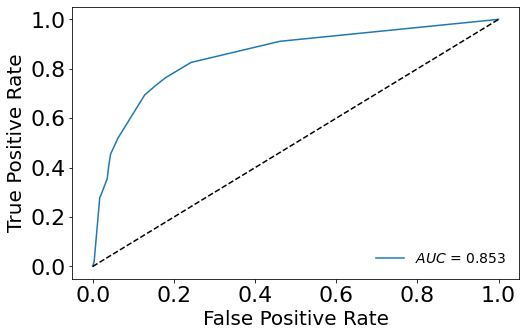

In [ ]:
y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Valence

In [ ]:
refvar="valence"
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

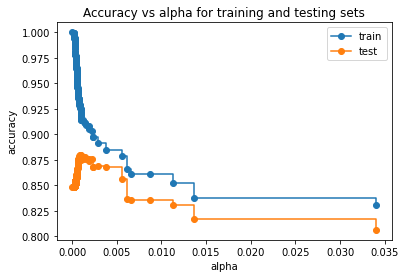

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

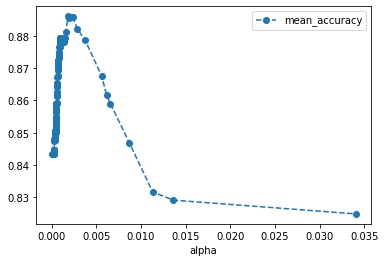

In [ ]:
alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

[Text(397.575, 378.5785714285714, 'dominance <= 0.595\ngini = 0.354\nsamples = 3511\nvalue = [2703, 808]\nclass = 0.0'),
 Text(167.4, 320.3357142857143, 'masculinity <= 0.35\ngini = 0.225\nsamples = 2845\nvalue = [2477, 368]\nclass = 0.0'),
 Text(83.7, 262.09285714285716, 'arousal <= 0.35\ngini = 0.497\nsamples = 321\nvalue = [149, 172]\nclass = 1.0'),
 Text(41.85, 203.85, 'gini = 0.313\nsamples = 72\nvalue = [58, 14]\nclass = 0.0'),
 Text(125.55000000000001, 203.85, 'dominance <= 0.52\ngini = 0.464\nsamples = 249\nvalue = [91, 158]\nclass = 1.0'),
 Text(83.7, 145.60714285714283, 'aoa <= 0.287\ngini = 0.5\nsamples = 142\nvalue = [69, 73]\nclass = 1.0'),
 Text(41.85, 87.3642857142857, 'gini = 0.289\nsamples = 40\nvalue = [7, 33]\nclass = 1.0'),
 Text(125.55000000000001, 87.3642857142857, 'semsize <= 0.652\ngini = 0.477\nsamples = 102\nvalue = [62, 40]\nclass = 0.0'),
 Text(83.7, 29.121428571428567, 'gini = 0.431\nsamples = 86\nvalue = [59, 27]\nclass = 0.0'),
 Text(167.4, 29.12142857142

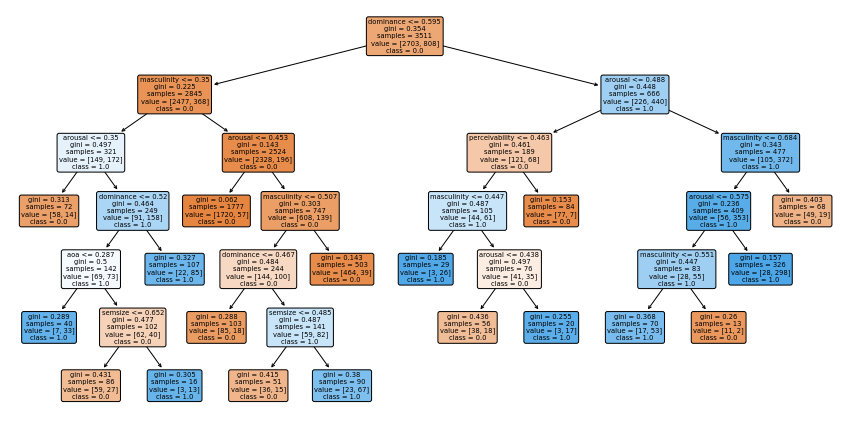

In [ ]:
clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plt.figure(figsize=(15,7.5))
clf_dt_pruned.classes_

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=[str(v) for v in clf_dt_pruned.classes_],
          feature_names=X.columns)


Accuracy 0.8761742100768574
F1-score 0.8712730807618025
              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       864
         1.0       0.83      0.66      0.74       307

    accuracy                           0.88      1171
   macro avg       0.86      0.81      0.83      1171
weighted avg       0.87      0.88      0.87      1171

0.889190493425021


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


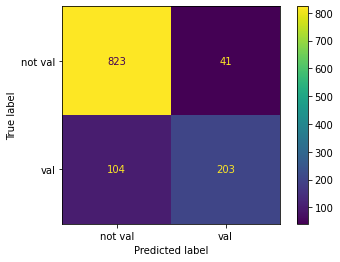

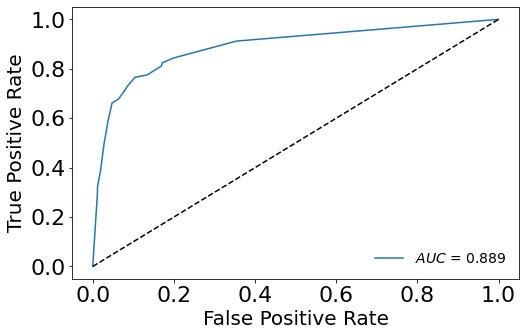

In [ ]:
y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not val','val'])


fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Dominance



In [ ]:
refvar="dominance"
taglio=0.57

In [ ]:
X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

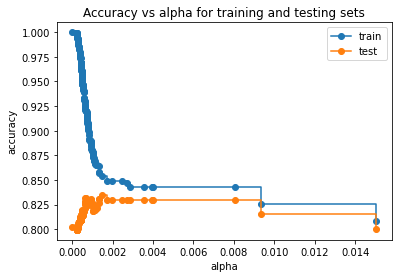

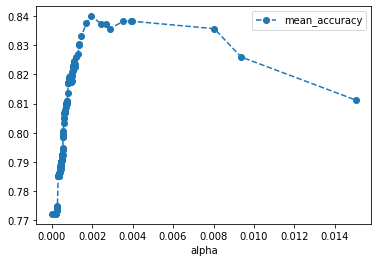

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.8300597779675492
F1-score 0.6223908918406071
              precision    recall  f1-score   support

         0.0       0.86      0.92      0.89       879
         1.0       0.70      0.56      0.62       292

    accuracy                           0.83      1171
   macro avg       0.78      0.74      0.76      1171
weighted avg       0.82      0.83      0.82      1171

0.8587416429005564


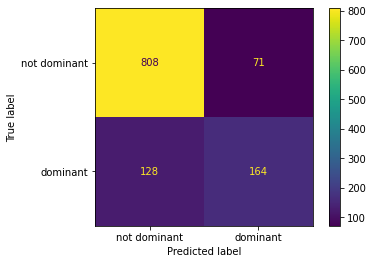

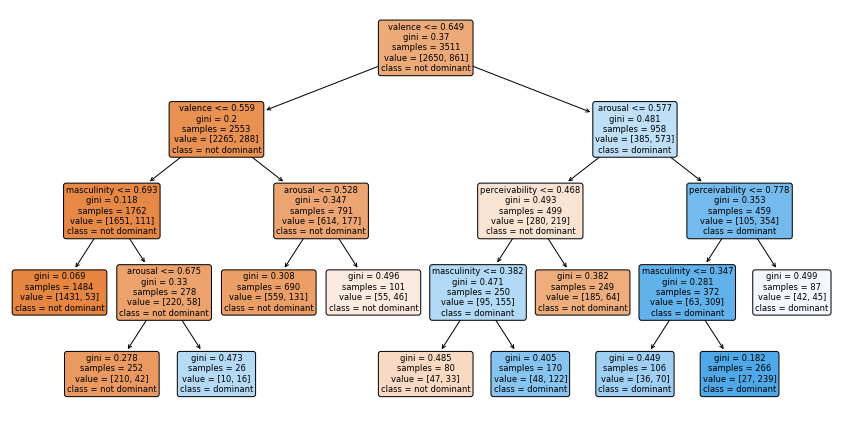

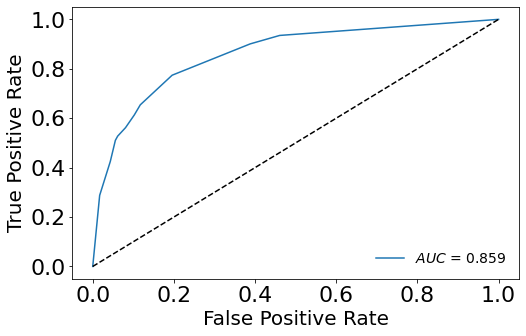

In [ ]:
clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not dominant','dominant'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not dominant","dominant"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Familiarity

In [ ]:
refvar="familiarity"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

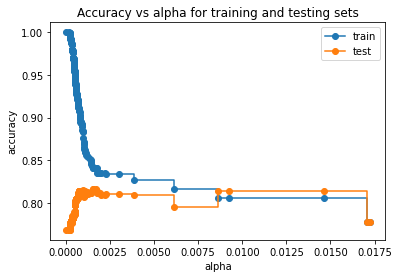

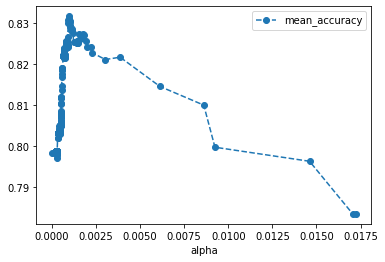

In [ ]:
path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.8121263877028181
F1-score 0.8692033293697977
              precision    recall  f1-score   support

         0.0       0.64      0.69      0.67       317
         1.0       0.88      0.86      0.87       854

    accuracy                           0.81      1171
   macro avg       0.76      0.77      0.77      1171
weighted avg       0.82      0.81      0.81      1171

0.8292743740719124


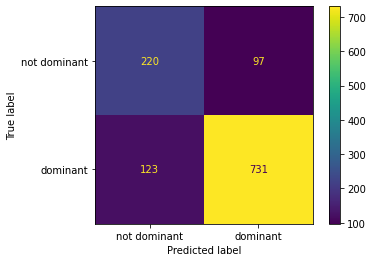

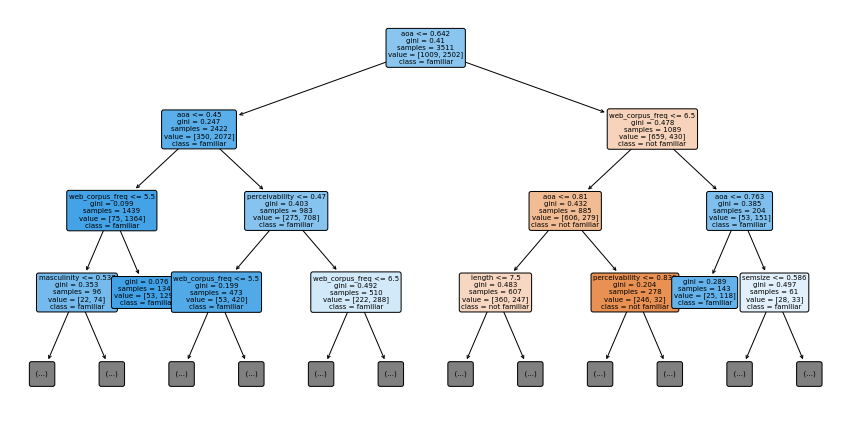

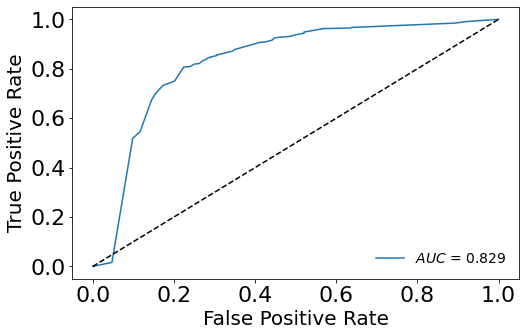

In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not dominant','dominant'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not familiar","familiar"],
          feature_names=X.columns,
          max_depth=3,
          fontsize=7)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)
plt.savefig('plot_of_tree.pdf')

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Semsize

In [ ]:
refvar="semsize"
taglio=0.63

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

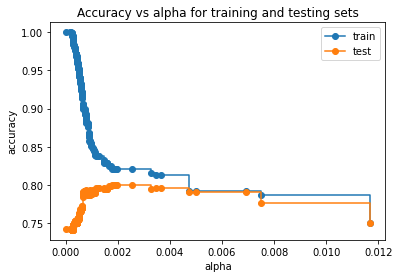

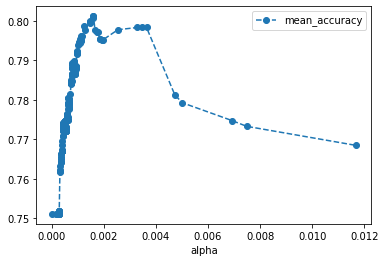

In [ ]:


path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.7950469684030743
F1-score [0.87261146 0.47598253]
              precision    recall  f1-score   support

         0.0       0.81      0.95      0.87       865
         1.0       0.72      0.36      0.48       306

    accuracy                           0.80      1171
   macro avg       0.76      0.65      0.67      1171
weighted avg       0.78      0.80      0.77      1171

0.7947183497676528


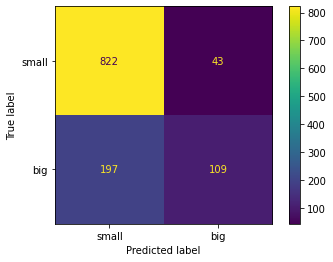

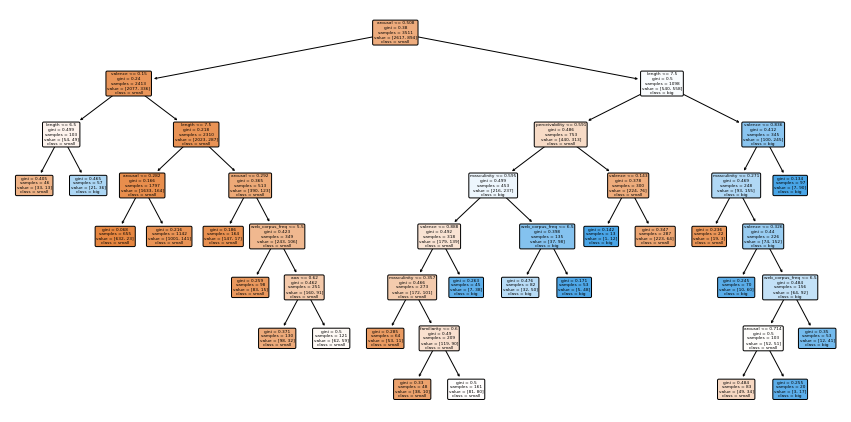

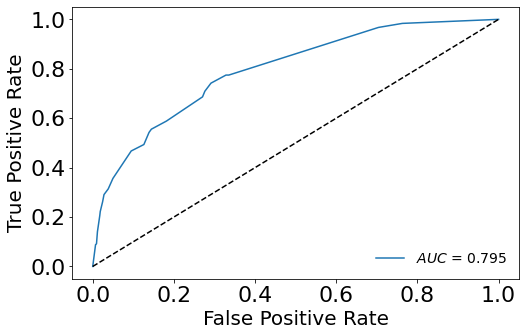

In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['small','big'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["small","big"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Masculinity

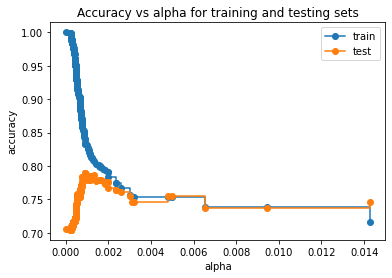

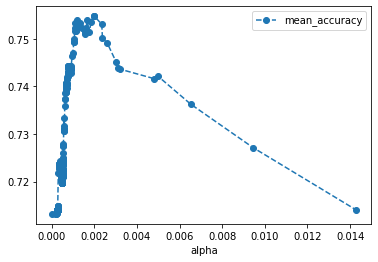

In [ ]:
refvar="masculinity"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Accuracy 0.7762596071733561
F1-score 0.5130111524163568
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       873
         1.0       0.57      0.46      0.51       298

    accuracy                           0.78      1171
   macro avg       0.70      0.67      0.68      1171
weighted avg       0.76      0.78      0.77      1171

0.747378475825857


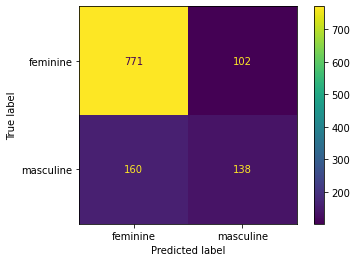

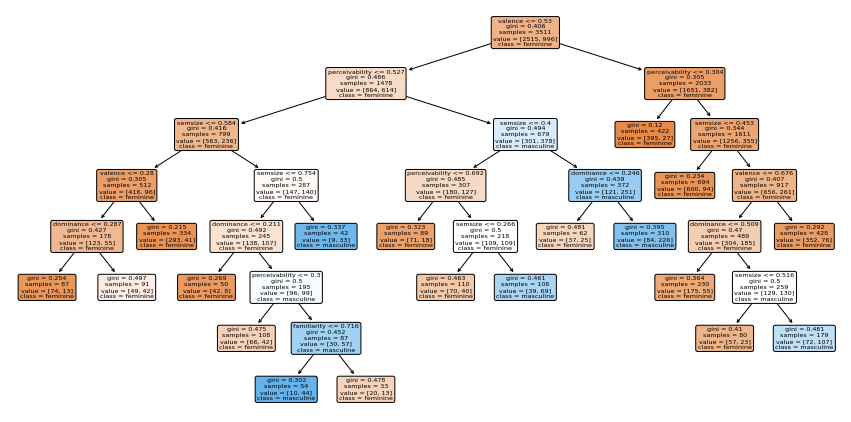

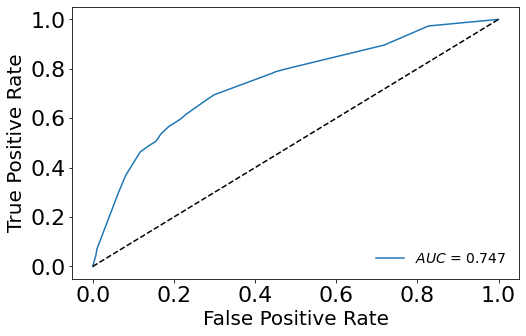

In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['feminine','masculine'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["feminine","masculine"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Polysemy

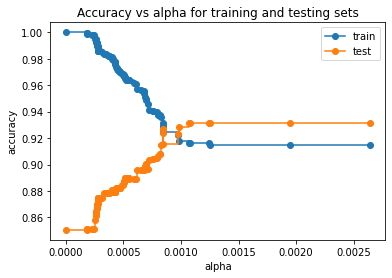

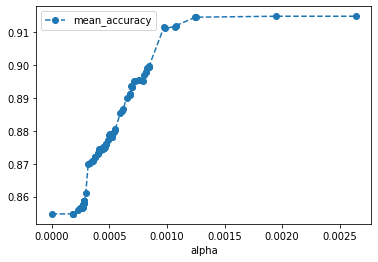

In [ ]:
refvar="polysemy"
taglio=0.63

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/l

Accuracy 0.9316823228010248
F1-score 0.8987315775207056
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      1091
           1       0.00      0.00      0.00        80

    accuracy                           0.93      1171
   macro avg       0.47      0.50      0.48      1171
weighted avg       0.87      0.93      0.90      1171

0.7247937671860678


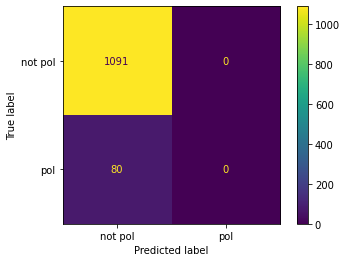

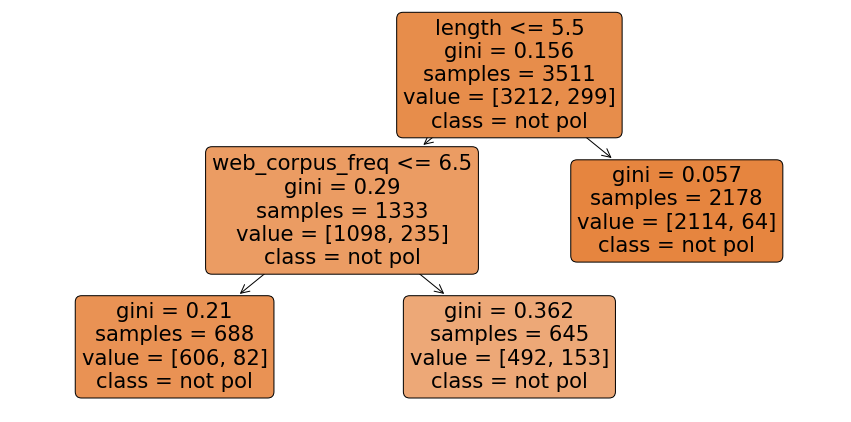

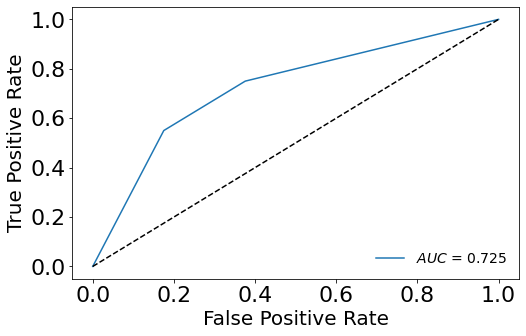

In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not pol','pol'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not pol","pol"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Perceivability

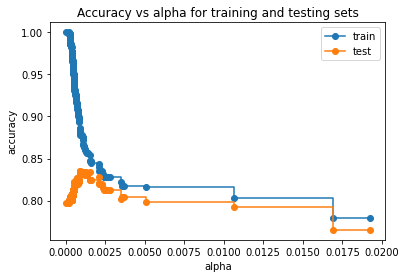

In [ ]:
refvar="perceivability"
taglio=0.8

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not peveivable','perveivable'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not perceivable","perceivable"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Age of Aquisition (binary)

In [ ]:
refvar="aoa"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0




X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='-')

In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['younger','older'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["younger","older"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Web Corpus Frequency

In [ ]:
refvar="web_corpus_freq"

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='--')


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['4','5','6','7','8','9'],
                      )

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=['4','5','6','7','8','9'],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average=None))
print(classification_report(y_test, y_pred))

print(clf_dt_pruned.predict_proba(X_test))

report = classification_report(y_test, y_pred, output_dict=True)

export = pd.DataFrame(report).transpose()

print(export.to_latex())

## 3.2 Classification by KNN

### Age of Aquisition

#### choice of k

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


refvar="aoa"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)


error_rate = []
for i in range(1,100):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [ ]:

acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))



In [ ]:

refvar="aoa"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_knn = KNeighborsClassifier(n_neighbors=error_rate.index(min(error_rate)))
clf_knn.fit(X, y)

In [ ]:
# apply KNN to train set
y_pred = clf_knn.predict(X_train)
y_pred[:5]

In [ ]:
y_train.values[:5]

In [ ]:
print('Accuracy', accuracy_score(y_train, y_pred))
print('F1', f1_score(y_train, y_pred, average='weighted'))
print( classification_report(y_train, y_pred) )

In [ ]:
# Confusion matrix for trainset
# TP, FN, FP, TN
confusion_matrix(y_train, y_pred)

In [ ]:
# apply KNN to test set
y_pred = clf_knn.predict(X_test)

In [ ]:
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(clf_knn,
                      X_test,
                      y_test,
                      display_labels=['younger','older'])


In [ ]:
y_score = clf_knn.predict_proba(X_test)

In [ ]:
fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Valence

#### choice of k

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


refvar="valence"
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)


error_rate = []
for i in range(1,100):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [ ]:

acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.accuracy_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc)))



In [ ]:

refvar="valence"
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_knn = KNeighborsClassifier(n_neighbors=error_rate.index(min(error_rate)))
clf_knn.fit(X, y)

y_pred = clf_knn.predict(X_train)
print('Accuracy', accuracy_score(y_train, y_pred))
print('F1', f1_score(y_train, y_pred, average='weighted'))
print( classification_report(y_train, y_pred) )

confusion_matrix(y_train, y_pred)


In [ ]:

y_pred = clf_knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(clf_knn,
                      X_test,
                      y_test,
                      display_labels=['not valuable','valuable'])

y_score = clf_knn.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)


plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Polysemy

#### choice of k

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


refvar="polysemy"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)


error_rate = []
for i in range(1,100):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [ ]:

acc = []
# Will take some time
from sklearn import metrics
for i in range(1,40):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(X_train,y_train)
    yhat = neigh.predict(X_test)
    acc.append(metrics.average_precision_score(y_test, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,40),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('F1 score vs. K Value')
plt.xlabel('K')
plt.ylabel('F1 Score')
print("Maximum F1:-",max(acc),"at K =",acc.index(max(acc)))



In [ ]:

refvar="polysemy"
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_knn = KNeighborsClassifier(n_neighbors=acc.index(max(acc)))
clf_knn.fit(X, y)

y_pred = clf_knn.predict(X_train)
print('Accuracy', accuracy_score(y_train, y_pred))
print('F1', f1_score(y_train, y_pred, average='weighted'))
print( classification_report(y_train, y_pred) )

confusion_matrix(y_train, y_pred)


In [ ]:
y_pred = clf_knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(clf_knn,
                      X_test,
                      y_test,
                      display_labels=['not polysemic','polysemic'])

y_score = clf_knn.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)


plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

## Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

### Valence

In [ ]:
refvar='valence'
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate model with 10 decision trees
model = RandomForestClassifier(n_estimators = 380, random_state = 42)
# Train the model on training data
ra=model.fit(X_train, y_train)


#TESTING THE MODEL BY PREDICTING ON TEST DATA
#AND CALCULATE THE ACCURACY SCORE

prediction_test = model.predict(X_test)
#print(y_test, prediction_test)

#Print the prediction accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))
#Test accuracy for various test sizes and see how it gets better with more training data

#One amazing feature of Random forest is that it provides us info on feature importances
# Get numerical feature importances
#importances = list(model.feature_importances_)

#Let us print them into a nice format.

feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)

y_pred = model.predict(X_train)
y_pred = model.predict(X_test)

plot_confusion_matrix(ra,
                      X_test,
                      y_test,
                      display_labels=['not val','val'],
                      )

y_score = model.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average='weighted'))
print(classification_report(y_test, y_pred))


### Polysemy

In [ ]:
refvar='polysemy'
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

# Instantiate model with 10 decision trees
model = RandomForestClassifier(n_estimators = 385, random_state = 42)
# Train the model on training data
ra=model.fit(X_train, y_train)


#TESTING THE MODEL BY PREDICTING ON TEST DATA
#AND CALCULATE THE ACCURACY SCORE

prediction_test = model.predict(X_test)
#print(y_test, prediction_test)

#Print the prediction accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))
#Test accuracy for various test sizes and see how it gets better with more training data

#One amazing feature of Random forest is that it provides us info on feature importances
# Get numerical feature importances
#importances = list(model.feature_importances_)

#Let us print them into a nice format.

feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)


y_pred = model.predict(X_train)
y_pred = model.predict(X_test)

plot_confusion_matrix(ra,
                      X_test,
                      y_test,
                      display_labels=['not pol','pol']
                      )

y_score = model.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

### Age of Aquisition

In [ ]:
refvar='aoa'
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Instantiate model with 10 decision trees
model = RandomForestClassifier(n_estimators = 380, random_state = 42)
# Train the model on training data
ra=model.fit(X_train, y_train)


#TESTING THE MODEL BY PREDICTING ON TEST DATA
#AND CALCULATE THE ACCURACY SCORE

prediction_test = model.predict(X_test)
#print(y_test, prediction_test)

#Print the prediction accuracy
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_test))
#Test accuracy for various test sizes and see how it gets better with more training data

#One amazing feature of Random forest is that it provides us info on feature importances
# Get numerical feature importances
#importances = list(model.feature_importances_)

#Let us print them into a nice format.

feature_list = list(X.columns)
feature_imp = pd.Series(model.feature_importances_,index=feature_list).sort_values(ascending=False)
print(feature_imp)


y_pred = model.predict(X_train)
y_pred = model.predict(X_test)

plot_confusion_matrix(ra,
                      X_test,
                      y_test,
                      display_labels=['younger','older']
                      )

y_score = model.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average='weighted'))
print(classification_report(y_test, y_pred))

### Out of bag error

In [ ]:

import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier

RANDOM_STATE = 42

refvar='valence'
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0


# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    (
        "RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(
            warm_start=True,
            oob_score=True,
            max_features="sqrt",
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(
            warm_start=True,
            max_features="log2",
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
    (
        "RandomForestClassifier, max_features=None",
        RandomForestClassifier(
            warm_start=True,
            max_features=None,
            oob_score=True,
            random_state=RANDOM_STATE,
        ),
    ),
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 1000

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

## Entropy (Decision Tree)

### Age of Acquisition

In [ ]:
refvar="aoa"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0




X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='-')

In [ ]:
alpha_results[(alpha_results['alpha']>0.002)
&
(alpha_results['alpha']<0.004)]


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)
print(ideal_ccp_alpha)


clf_dt_pruned = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['young','old'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["young","old"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Polysemy

In [ ]:
refvar="polysemy"
taglio=0.6

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0




X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='entropy',random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='-')

In [ ]:
alpha_results[(alpha_results['alpha']>0.002)
]


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)
print(ideal_ccp_alpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not polysemic','polysemic'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not polysemic","polysemic"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

### Valence

In [ ]:
refvar="valence"
taglio=0.67

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

y_up_index = y >= taglio

y[y_up_index]=1

y_zero_index = y < taglio

y[y_zero_index]=0




X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   yerr='std',
                   marker='o',
                   linestyle='-')

In [ ]:
alpha_results[(alpha_results['alpha']>0.0025)
&
(alpha_results['alpha']<0.0035)]


In [ ]:
indexmax = alpha_results[['mean_accuracy']].idxmax()

maxalpha=alpha_results.loc[indexmax,'alpha']

ideal_ccp_alpha = float(maxalpha)

print(ideal_ccp_alpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['not valuable','valuable'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=["not valuable","valuable"],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

y_score = clf_dt_pruned.predict_proba(X_test)

fpr, tpr, th = roc_curve(y_test, y_score[:,1])

roc_auc = auc(fpr, tpr)
print(roc_auc)

plt.figure(figsize=(8,5))

plt.plot(fpr, tpr, label='$AUC$ = %.3f' % (roc_auc))
plt.legend(loc="lower right", fontsize=14, frameon=False)

plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20)

plt.tick_params(axis='both', which='major', labelsize=22)
plt.show()

# Multisplit target

In [ ]:
df_class_ref = dfprepro.copy()
dataframe = [df_class_ref]
for dataset in dataframe:
    dataset.loc[(dataset["aoa"] > 1) & (dataset["aoa"] <= 2), "aoa"] = 1
    dataset.loc[(dataset["aoa"] > 2)& (dataset["aoa"] <= 3), "aoa"] = 2
    dataset.loc[(dataset["aoa"] > 3)& (dataset["aoa"] <= 4), "aoa"] = 3
    dataset.loc[(dataset["aoa"] > 4)& (dataset["aoa"] <= 5), "aoa"] = 4
    dataset.loc[(dataset["aoa"] > 5)& (dataset["aoa"] <= 6), "aoa"] = 5
    dataset.loc[(dataset["aoa"] > 6)&( dataset["aoa"] <= 7), "aoa"] = 6
    dataset.loc[(dataset["aoa"] > 7), "aoa"] = 7
df_class_ref.head()

In [ ]:
var_to_scale=["arousal","valence","dominance","familiarity","semsize","masculinity","perceivability"]

features = df_class_ref[var_to_scale]
scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)

df_class_ref[var_to_scale] = features
df_class_ref.head()

### Age of Aquisition (DT)

In [ ]:
refvar="aoa"

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42)

clf_dt = clf_dt.fit(X_train, y_train)

path = clf_dt.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas
ccp_alphas = ccp_alphas[:-1]

clf_dts=[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
  clf_dt.fit(X_train, y_train)
  clf_dts.append(clf_dt)

train_scores = [clf_dt.score(X_train, y_train) for clf_dt in clf_dts]
test_scores = [clf_dt.score(X_test, y_test) for clf_dt in clf_dts]

fig, ax =plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas,train_scores, marker ='o',label='train',drawstyle='steps-post')

ax.plot(ccp_alphas,test_scores, marker ='o',label='test',drawstyle='steps-post')
ax.legend()
plt.show()

alpha_loop_values =[]

for ccp_alpha in ccp_alphas:
  clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=0, ccp_alpha=ccp_alpha)
  scores= cross_val_score(clf_dt,X_train,y_train, cv=10)
  alpha_loop_values.append([ccp_alpha,np.mean(scores), np.std(scores)])

alpha_results = pd.DataFrame(alpha_loop_values,
                               columns=['alpha','mean_accuracy','std'])
  
alpha_results.plot(x='alpha',
                   y='mean_accuracy',
                   marker='o',
                   linestyle='--')


In [ ]:
alpha_results[(alpha_results['alpha']>0.0015)
&
(alpha_results['alpha']<0.0022)]

In [ ]:
ideal_ccp_alpha = 0.001858

ideal_ccp_alpha = float(ideal_ccp_alpha)

clf_dt_pruned = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1,random_state=42, ccp_alpha=ideal_ccp_alpha)

clf_dt_pruned = clf_dt_pruned.fit(X_train, y_train)

plot_confusion_matrix(clf_dt_pruned,
                      X_test,
                      y_test,
                      display_labels=['0-2','2-4','4-6','6-8','8-10','10-12'])

plt.figure(figsize=(15,7.5))

from sklearn.tree import plot_tree
plot_tree(clf_dt_pruned,
          filled=True,
          rounded=True,
          class_names=['0-2','2-4','4-6','6-8','8-10','10-12'],
          feature_names=X.columns)

y_pred = clf_dt_pruned.predict(X_train)
y_pred = clf_dt_pruned.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred,average=None))
print(classification_report(y_test, y_pred))

print(clf_dt_pruned.predict_proba(X_test))

report = classification_report(y_test, y_pred, output_dict=True)

export = pd.DataFrame(report).transpose()

print(export.to_latex())

plt.show()

### Age of Acquisition (KNN)

#### choice of k

In [ ]:
from sklearn.neighbors import KNeighborsClassifier


refvar="aoa"

X=df_class_ref.drop(refvar,axis=1).copy()

y=df_class_ref[refvar].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

k = 4  
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)
Pred_y = neigh.predict(X_test)


error_rate = []
for i in range(1,100):
 knn = KNeighborsClassifier(n_neighbors=i)
 knn.fit(X_train,y_train)
 pred_i = knn.predict(X_test)
 error_rate.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
print("Minimum error:-",min(error_rate),"at K =",error_rate.index(min(error_rate)))

In [ ]:
clf_knn = KNeighborsClassifier(n_neighbors=14)
clf_knn.fit(X, y)

y_pred = clf_knn.predict(X_train)
print('Accuracy', accuracy_score(y_train, y_pred))
print('F1', f1_score(y_train, y_pred, average='weighted'))
print( classification_report(y_train, y_pred) )

confusion_matrix(y_train, y_pred)


In [ ]:
y_pred = clf_knn.predict(X_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))

print(confusion_matrix(y_test, y_pred))

plot_confusion_matrix(clf_knn,
                      X_test,
                      y_test,
                      display_labels=['0-2','2-4','4-6','6-8','8-10'])

y_score = clf_knn.predict_proba(X_test)

report = classification_report(y_test, y_pred, output_dict=True)

export = pd.DataFrame(report).transpose()

print(export.to_latex())